<a href="https://colab.research.google.com/github/cherylktt/tensorflow/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem. There are 2 main benefits:
1. Can leverage an existing neural network architecture proven to wrok on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [1]:
# Are we using a GPU?
!nvidia-smi

Tue Apr 19 18:06:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-04-19 18:06:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.129.128, 209.85.234.128, 74.125.124.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.129.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  86.4MB/s    in 1.9s    

2022-04-19 18:06:29 (86.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# How many images in each folder?
import os

# Walk through 10% data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

Instead of 750 images in each training class, we now only have 75 images (10x less examples for our model to learn).

There are the same number of images in each testing class as before.

## Creating data loaders (preparing the data)

We'll use the  `ImageDataGenerator` class to load in our images in batches.

In [4]:
# Set up data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

**TensorBoard** - log the performance of multiple models and view and compare these models in a visual way on TensorBoard. helpful to compare the results of different models on your data.

**ModelCheckpoint** - save your model as it trains so you can stop training if needed and come back to continue at where you left off. helpful if training takes a long time and can't be done in one sitting.

**EarlyStopping** - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. helpful when you have a large dataset and don't know how long training will take.

In [5]:
# Create TensorBoard callback (functionised because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # create directory path to store the log files of the experiment
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Creating models using TensorFlow Hub

In the past, we've used TensorFlow to create our own models layer by layer from scratch. Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub. We can access pretrained models on https://tfhub.dev.

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [6]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer, 
      should be equal to number of target classes, default 10.

  Returns:
    A compiled Keras Sequential model with model_url as feature 
    extractor layer and Dense output layer with num_classes output neurons.
    loss = "categorical_crossentropy",
    optimizer = Adam()
    metrics = "accuracy"
  """

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # (224, 224, 3)

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

  return model

### Creating and Testing ResNet TensorFlow Hub Feature Extraction Model

In [9]:
# Create Resnet model and compile it
resnet_model = create_model(resnet_url, 
                            num_classes=train_data_10_percent.num_classes)

In [10]:
# Fit the model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220419-180701
Epoch 1/5
24/24 [==============================] - 41s 1s/step - loss: 1.9954 - accuracy: 0.3147 - val_loss: 1.1898 - val_accuracy: 0.6364
Epoch 2/5
24/24 [==============================] - 22s 962ms/step - loss: 0.8840 - accuracy: 0.7387 - val_loss: 0.8239 - val_accuracy: 0.7436
Epoch 3/5
24/24 [==============================] - 22s 952ms/step - loss: 0.6125 - accuracy: 0.8307 - val_loss: 0.7357 - val_accuracy: 0.7632
Epoch 4/5
24/24 [==============================] - 22s 956ms/step - loss: 0.4633 - accuracy: 0.8733 - val_loss: 0.6781 - val_accuracy: 0.7892
Epoch 5/5
24/24 [==============================] - 22s 954ms/step - loss: 0.3696 - accuracy: 0.9187 - val_loss: 0.6578 - val_accuracy: 0.7868


> Our transfer learning feature extractor model out performed all of the previous models we built by hand (substantially) and in a much quicker training time, and with only 10% of the training examples.

In [11]:
# Let's create a function to plot our loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs did we run for

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure() # create a new figure
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

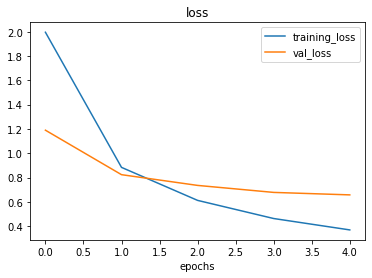

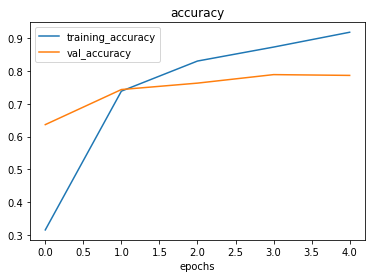

In [12]:
# Plot the training curves for the resnet model
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

Details on EfficientNet - https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

In [13]:
# Create efficientnet model and compile it
efficientnet_model = create_model(efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Fit the model to our data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20220419-180958
Epoch 1/5
24/24 [==============================] - 35s 948ms/step - loss: 1.8344 - accuracy: 0.4480 - val_loss: 1.3142 - val_accuracy: 0.7128
Epoch 2/5
24/24 [==============================] - 20s 850ms/step - loss: 1.0612 - accuracy: 0.7600 - val_loss: 0.8868 - val_accuracy: 0.8088
Epoch 3/5
24/24 [==============================] - 20s 849ms/step - loss: 0.7594 - accuracy: 0.8387 - val_loss: 0.7123 - val_accuracy: 0.8356
Epoch 4/5
24/24 [==============================] - 20s 849ms/step - loss: 0.6132 - accuracy: 0.8627 - val_loss: 0.6255 - val_accuracy: 0.8480
Epoch 5/5
24/24 [==============================] - 20s 847ms/step - loss: 0.5154 - accuracy: 0.8987 - val_loss: 0.5651 - val_accuracy: 0.8600


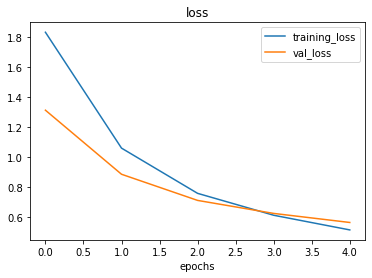

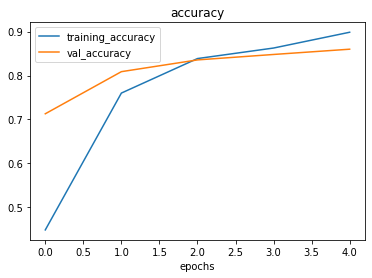

In [14]:
# Plot the training curves for the efficientnet model
plot_loss_curves(efficientnet_history)

In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [16]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


> The only trainable parameters are in the output layer. Since we set trainable to "false", our feature extraction layer does not contain any trainable parameters.

In [17]:
# How many layers does our efficientnetB0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes whatsoever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - using pre-learned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes of ImageNet -> 10 classes of food)
* **"Fine-tuning" transfer learning** - using the pre-learned patterns of an existing model and fine-tuning many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> **Note:** When you upload things to TensorBoard.dev, your experiments are public.

In [19]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data." \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/awVATlJeRmivrQgenayghA/

[2022-04-19T18:12:58] Started scanning logdir.
[2022-04-19T18:13:00] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.5 MB)
[2022-04-19T18:13:00] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/awVATlJeRmivrQgenayghA/


Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/awVATlJeRmivrQgenayghA/

From TensorBoard, we can conclude that EfficientNet B0 performed way better than ResNet V2 50 when it came to the test data.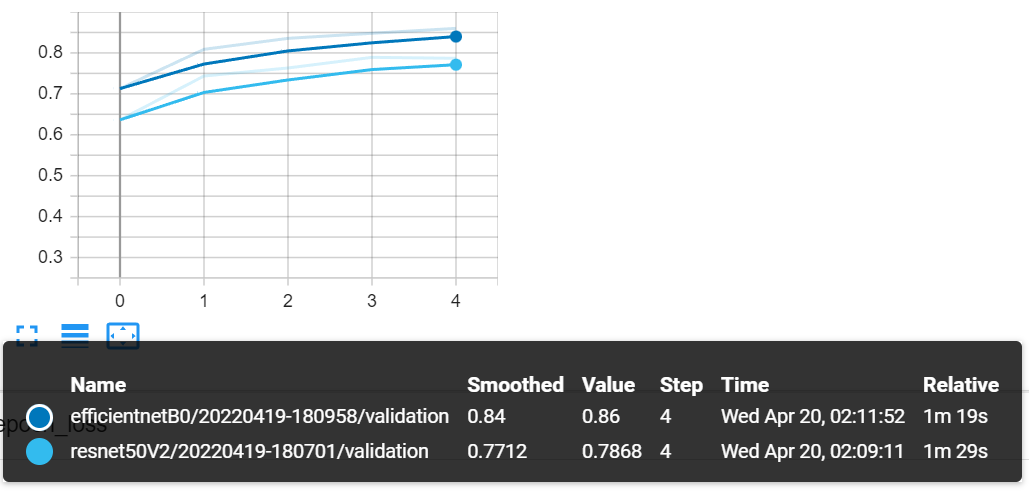

In [20]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

https://tensorboard.dev/experiment/awVATlJeRmivrQgenayghA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data.
	Id                   awVATlJeRmivrQgenayghA
	Created              2022-04-19 18:12:58 (2 minutes ago)
	Updated              2022-04-19 18:13:00 (2 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5794963
Total: 1 experiment(s)


In [75]:
# Delete an experiment
# !tensorboard dev delete --experiment_id {id}

In [76]:
# Confirm the deletion by re-checking what experiments you have left
# !tensorboard dev list

**Note:** [Weights and Biases](https://wandb.ai/site) works very well with TensorBoard.

# Exercises

Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction [`mobilenet_v2_100_224/feature_vector`](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4) from TensorFlow Hub, how does it perform compared to our other models?

In [21]:
# Set up the model url
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [22]:
# Create mobilenet model and compile it
mobilenet_model = create_model(mobilenet_url,
                               num_classes=train_data_10_percent.num_classes)

# Fit the model to the data
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                               experiment_name="mobilenet100V2")])

Saving TensorBoard log files to: tensorflow_hub/mobilenet100V2/20220419-181603
Epoch 1/5
24/24 [==============================] - 26s 870ms/step - loss: 1.9381 - accuracy: 0.3520 - val_loss: 1.3387 - val_accuracy: 0.5888
Epoch 2/5
24/24 [==============================] - 18s 791ms/step - loss: 1.0243 - accuracy: 0.7200 - val_loss: 0.9168 - val_accuracy: 0.7260
Epoch 3/5
24/24 [==============================] - 19s 810ms/step - loss: 0.7193 - accuracy: 0.8053 - val_loss: 0.7615 - val_accuracy: 0.7768
Epoch 4/5
24/24 [==============================] - 19s 827ms/step - loss: 0.5582 - accuracy: 0.8560 - val_loss: 0.6973 - val_accuracy: 0.7852
Epoch 5/5
24/24 [==============================] - 19s 826ms/step - loss: 0.4707 - accuracy: 0.8987 - val_loss: 0.6486 - val_accuracy: 0.8024


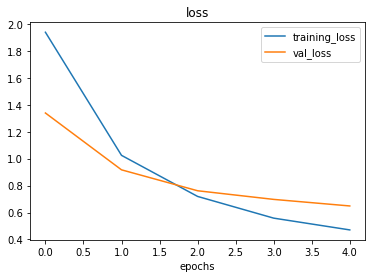

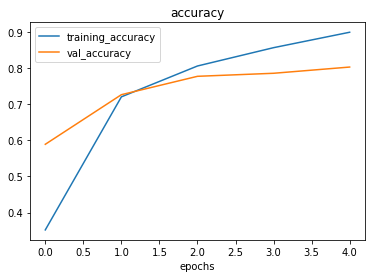

In [23]:
# Plot the loss curves
plot_loss_curves(mobilenet_history)

In [24]:
# Compare the results with the other models using TensorBoard
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "MobileNet100V2 Vs. EfficientNetB0 Vs. ResNet50V2" \
  --description "Comparing 3 different TF Hub feature extraction model architectures using 10% of the training data." \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/j7YeWQidQC622Hw27TMfxQ/

[2022-04-19T18:17:51] Started scanning logdir.
[2022-04-19T18:17:54] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (7.1 MB)
[2022-04-19T18:17:54] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/j7YeWQidQC622Hw27TMfxQ/


From TensorBoard, we can conclude that MobileNet V2 100 performed slightly better than ResNet V2 50 on the test data but not as well as EfficientNet B0.
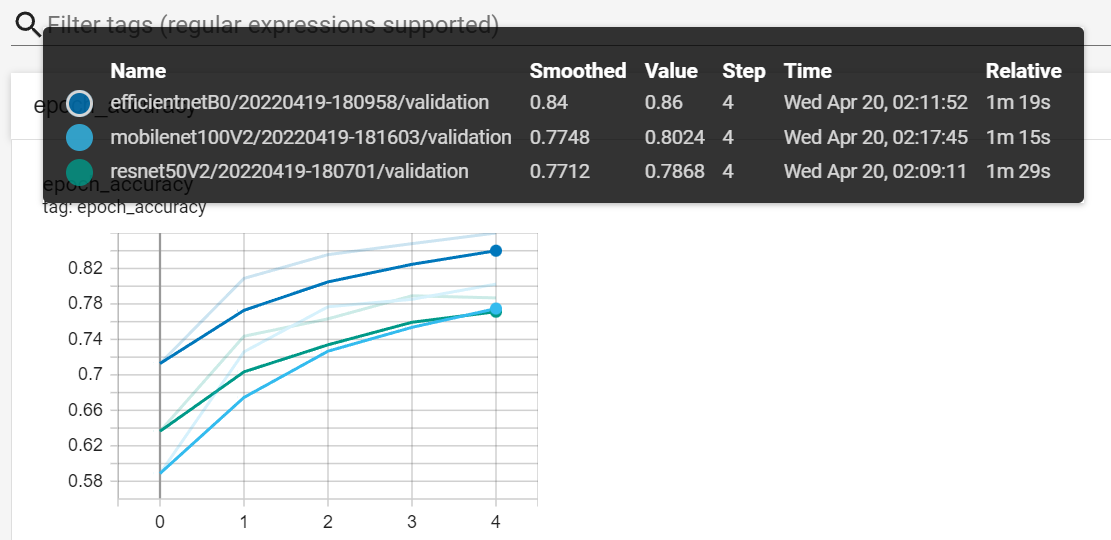